Cycles
======

The [cycles](api/ktk.cycles.rst) module allows detecting cycles in TimeSeries, time-normalize these cycles and select the most repeatable ones.

.. warning::
    This module is experimental. Function names, signatures and implementations may change anytime.

In this tutorial, we will load kinetics data from wheelchair propulsion using a csv file, and then manipulate propulsion cycles.

In [1]:
import ktk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the csv file
df = pd.read_csv('data/timeseries/smartwheel.csv',
                 usecols=[18, 19, 20, 21, 22, 23],
                 names=['Forces[0]', 'Forces[1]', 'Forces[2]',
                        'Moments[0]', 'Moments[1]', 'Moments[2]'],
                 nrows=5000)

# Assign time to the DataFrame's index, where the sampling rate is 240 Hz.
df.index = np.arange(df.shape[0]) / 240

# Convert this DataFrame to a TimeSeries
ts = ktk.TimeSeries.from_dataframe(df)

At this point, we have a TimeSeries that contains forces and moments.

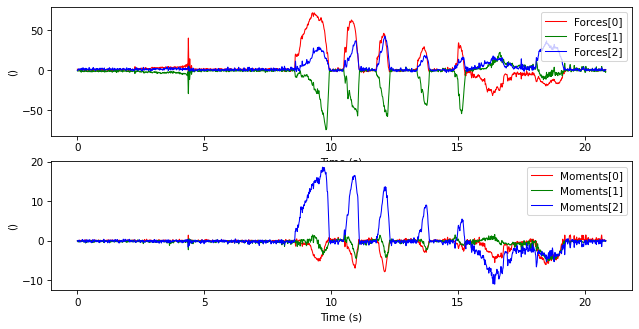

In [2]:
plt.subplot(2, 1, 1)
ts.plot('Forces')
plt.subplot(2, 1, 2)
ts.plot('Moments')

Detecting cycles
----------------

The [ktk.cycles.detect_cycles](api/ktk.cycles.rst#ktk.cycles.detect_cycles) allows detecting cycles in a TimeSeries, using a signal from this TimeSeries.

Here, to detect the cycles in these data, we will add a third data, the total force (Ftot) as the basis for cycle detection.

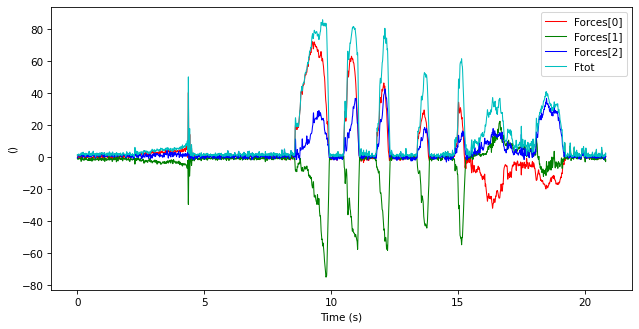

In [3]:
ts.data['Ftot'] = np.sqrt(np.sum(ts.data['Forces'] ** 2, 1))
ts.plot(['Forces', 'Ftot'])

Now let see how detecting cycles works. We will define the threshold values visually based on the figure above.

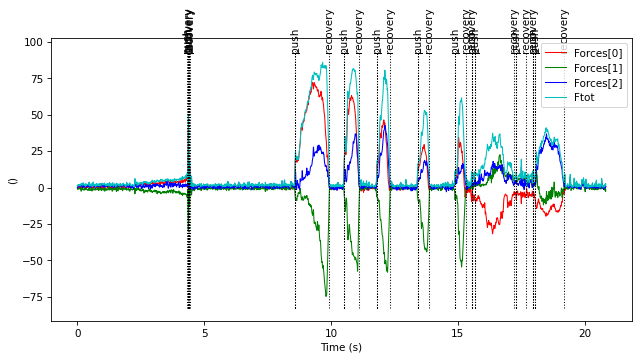

In [4]:
test = ktk.cycles.detect_cycles(ts, 'Ftot',
                                event_name1='push',
                                event_name2='recovery',
                                raising_threshold=10,
                                falling_threshold=5)
test.plot(['Forces', 'Ftot'])

We observe that several (short) cycles were wrongly detected, for example during the first spike, which is not a push but a synchronization spike and not a push. We can reject those cycles by specifying minimal lengths for both phases.

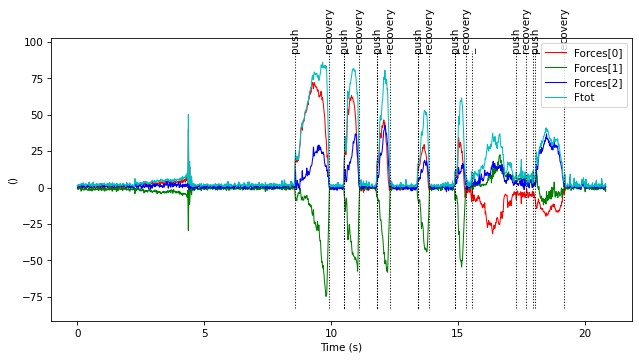

In [5]:
test = ktk.cycles.detect_cycles(ts, 'Ftot',
                                event_name1='push',
                                event_name2='recovery',
                                raising_threshold=10,
                                falling_threshold=5,
                                min_length1=0.2,
                                min_length2=0.2)
test.plot(['Forces', 'Ftot'])

We also see that the detected cycles at the end are erratic and include invalid pushes that should be excluded. We can exclude these pushes by specifying a target values for both phases (values that should be reached during the phase)

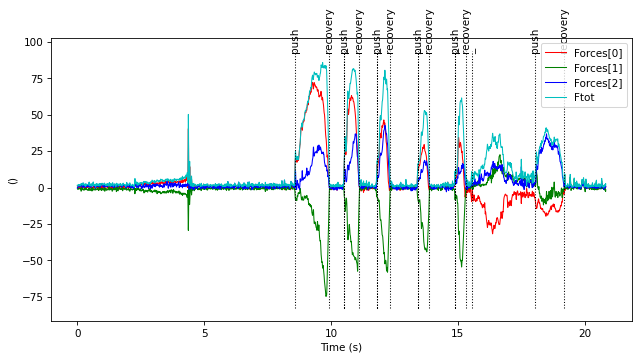

In [6]:
ts_with_events = ktk.cycles.detect_cycles(ts, 'Ftot',
                                          event_name1='push',
                                          event_name2='recovery',
                                          raising_threshold=10,
                                          falling_threshold=5,
                                          min_length1=0.2,
                                          min_length2=0.2,
                                          target_height1=25)
ts_with_events.plot(['Forces', 'Ftot'])

Time-normalizing cycles
-----------------------

Once the cycles have been detected, we can time-normalize these cycles using [time_normalize](api/ktk.cycles.rst#ktk.cycles.time_normalize) to get them on the same time scale (a percentage of the cycle).

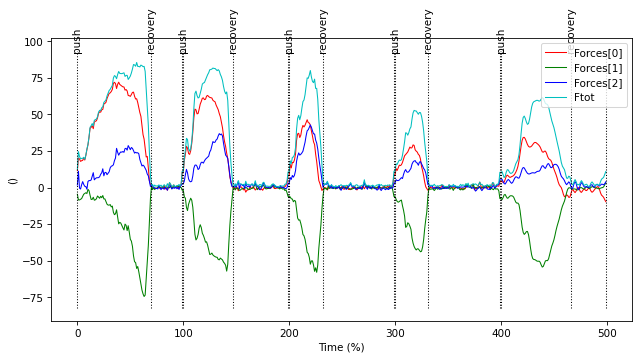

In [7]:
ts_normalized_on_cycle = ktk.cycles.time_normalize(ts_with_events, 'push', '_')
ts_normalized_on_cycle.plot(['Forces', 'Ftot'])

To time-normalize only during the push phase:

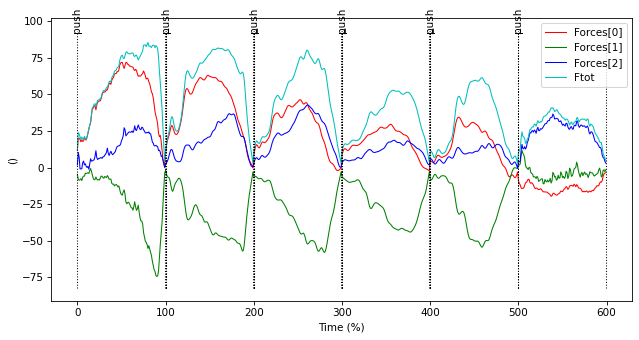

In [8]:
ts_normalized_on_push = ktk.cycles.time_normalize(ts_with_events, 'push', 'recovery')
ts_normalized_on_push.plot(['Forces', 'Ftot'])

Combining the cycles
--------------------
Time-normalizing cycles is often performed in order to perform further operations (e.g., computing and visualizing the average cycle). Therefore, the next logical step is often to group the cycles into indexable arrays. This is the aim of the [ktk.cycles.stack_normalized_data](api/ktk.cycles.rst#ktk.cycles.stack_normalized_data) function.

In this example, we will stack the data from the last computed TimeSeries.

In [9]:
data = ktk.cycles.stack_normalized_data(ts_normalized_on_push)
data

{
       'Forces': <array of shape (6, 100, 3)>,
         'Ftot': <array of shape (6, 100)>,
      'Moments': <array of shape (6, 100, 3)>
}

The first dimension of each dictionary's entry corresponds to the cycles. It becomes easier to perform operations on cycles. For example, we could want to plot the propulsive moment `Mz` (Moments[2]) in each cycle one of top of the other:

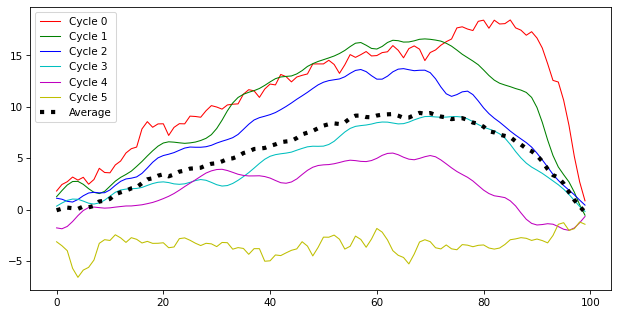

In [10]:
# Plot every cycles
for i_cycle in range(6):
    plt.plot(
        data['Moments'][i_cycle, :, 2],
        label=f"Cycle {i_cycle}")
    
# Plot the average cycle
plt.plot(
    np.mean(data['Moments'][:, :, 2], axis=0),
    'k:', linewidth=4, label="Average")
    
plt.legend()
plt.show()

Finding the most repeatable cycles
----------------------------------

In the previous step, we calculated an average cycle. However, this average cycle was calculated on cycles that were somewhat different. We can use the [ktk.cycles.most_repeatable_cycles](api/ktk.cycles.rst#ktk.cycles.most_repeatable_cycles) to obtain an ordered list from the most repeatable cycles to the most different one. Here, we will base this analysis on the `Ftot` signal.

In [11]:
index = ktk.cycles.most_repeatable_cycles(data['Ftot'])
index                             

[1, 2, 0, 3, 4, 5]

Now let's make the same plot of `Mz`, but based only on the three most repeatable cycles.

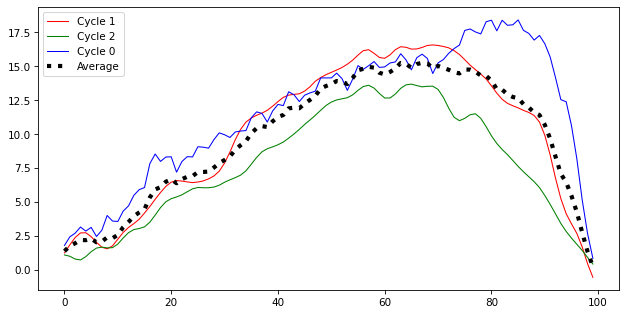

In [12]:
# Plot the three cycles
for i_cycle in index[0:3]:
    plt.plot(
        data['Moments'][i_cycle, :, 2],
        label=f"Cycle {i_cycle}")
    
# Plot the average cycle
plt.plot(
    np.mean(data['Moments'][index[0:3], :, 2], axis=0),
    'k:', linewidth=4, label="Average")
    
plt.legend()
plt.show()

For more information on cycles, please check the [API Reference](api/ktk.cycles.rst).